
# Stock Price Prediction Model Notebook

This Jupyter Notebook details the process of building and training neural network models to predict stock prices using PyTorch.


In [ ]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt



## Data Preprocessing Functions


In [2]:

def clean_numeric_data(df):
    """Clean numeric columns by removing commas and converting to float"""
    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    for column in numeric_columns:
        df[column] = df[column].astype(str).str.replace(',', '').astype(float)
    return df

def prepare_data(train_data, test_data, seq_length=60):
    """Prepare and preprocess the data for training"""
    train_data = train_data.copy()
    test_data = test_data.copy()

    # Clean the data
    train_data = clean_numeric_data(train_data)
    test_data = clean_numeric_data(test_data)

    features = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Scale the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_scaled = scaler.fit_transform(train_data[features])
    test_scaled = scaler.transform(test_data[features])

    # Create sequences for training data
    X_train, y_train = [], []
    for i in range(len(train_scaled) - seq_length):
        X_train.append(train_scaled[i:(i + seq_length)])
        y_train.append(train_scaled[i + seq_length, 3])  # 3 is the index for 'Close'

    # Create sequences for test data
    combined_data = np.vstack([train_scaled[-seq_length:], test_scaled])
    X_test, y_test = [], []
    for i in range(len(test_scaled)):
        X_test.append(combined_data[i:i + seq_length])
        y_test.append(test_scaled[i, 3])

    return (np.array(X_train), np.array(y_train),
            np.array(X_test), np.array(y_test), scaler)




## Dataset Class


In [3]:

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



## Model Classes


In [4]:
class BasicLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=1, dropout=0.2):
        super(BasicLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

class BasicGRU(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=1, dropout=0.2):
        super(BasicGRU, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        return self.fc(gru_out[:, -1, :])

class BasicRNN(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=1, dropout=0.2):
        super(BasicRNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        return self.fc(rnn_out[:, -1, :])



## Training Functions


In [5]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                epochs=100, early_stopping_patience=10):
    """Train the model with early stopping"""
    model.train()
    train_losses = []
    val_losses = []
    min_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred.squeeze(), y_batch)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Early stopping check
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Training Loss: {avg_train_loss:.6f}')
            print(f'Validation Loss: {avg_val_loss:.6f}')

    return train_losses, val_losses

def evaluate_model(model, test_loader, scaler):
    """Evaluate the model and calculate metrics"""
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            predictions.extend(y_pred.squeeze().numpy())
            actuals.extend(y_batch.numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Inverse transform predictions and actuals
    pred_scaled = np.zeros((len(predictions), 5))
    actual_scaled = np.zeros((len(actuals), 5))
    pred_scaled[:, 3] = predictions
    actual_scaled[:, 3] = actuals

    pred_original = scaler.inverse_transform(pred_scaled)[:, 3]
    actual_original = scaler.inverse_transform(actual_scaled)[:, 3]

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actual_original, pred_original))
    mape = mean_absolute_percentage_error(actual_original, pred_original)
    r2 = r2_score(actual_original, pred_original)

    return pred_original, actual_original, rmse, mape, r2



## Plotting Functions


In [6]:
def plot_results(train_losses, val_losses, predictions, actuals, model_name):
    """Plot training history and predictions"""
    plt.figure(figsize=(15, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot predictions vs actuals
    plt.subplot(1, 2, 2)
    plt.plot(actuals, label='Actual', marker='o')
    plt.plot(predictions, label='Predicted', marker='x')
    plt.title(f'{model_name} Stock Price Predictions')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## Experiment Function


In [7]:
def run_experiment(model_type='LSTM', hidden_size=64, num_layers=1,
                  learning_rate=0.01, dropout=0.2, batch_size=32):
    """Run a complete experiment with the specified configuration"""
    # Load data
    train_data = pd.read_csv('Google_Stock_Price_Train.csv')
    test_data = pd.read_csv('Google_Stock_Price_Test.csv')

    # Prepare data
    X_train, y_train, X_test, y_test, scaler = prepare_data(train_data, test_data)

    # Split training data into train and validation sets
    train_size = int(0.8 * len(X_train))
    X_train_final = X_train[:train_size]
    y_train_final = y_train[:train_size]
    X_val = X_train[train_size:]
    y_val = y_train[train_size:]

    # Create datasets and data loaders
    train_dataset = StockDataset(X_train_final, y_train_final)
    val_dataset = StockDataset(X_val, y_val)
    test_dataset = StockDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize model based on type
    if model_type == 'LSTM':
        model = BasicLSTM(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    elif model_type == 'GRU':
        model = BasicGRU(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    else:  # RNN
        model = BasicRNN(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train model
    print(f"\nTraining {model_type} model...")
    train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer)

    # Evaluate model
    predictions, actuals, rmse, mape, r2 = evaluate_model(model, test_loader, scaler)

    # Print results
    print(f"\n{model_type} Results:")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAPE: {mape*100:.2f}%")
    print(f"R² Score: {r2:.4f}")

    # Plot results
    plot_results(train_losses, val_losses, predictions, actuals, model_type)

    # Create a result dictionary with all required fields
    result = {
        'model_type': model_type,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'learning_rate': learning_rate,
        'dropout': dropout,
        'rmse': float(rmse),  # Ensure numeric type
        'mape': float(mape),  # Ensure numeric type
        'r2': float(r2)       # Ensure numeric type
    }

    # Print individual result
    print(f"\nResults for {model_type}:")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAPE: {mape*100:.2f}%")
    print(f"R² Score: {r2:.4f}")

    return result


## Main Execution


Running experiment with configuration:
{'model_type': 'LSTM', 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.2, 'learning_rate': 0.01}

Training LSTM model...
Epoch [10/100]
Training Loss: 0.004338
Validation Loss: 0.000794
Epoch [20/100]
Training Loss: 0.003990
Validation Loss: 0.002542
Early stopping triggered at epoch 27

LSTM Results:
RMSE: $12.98
MAPE: 1.41%
R² Score: -0.0162


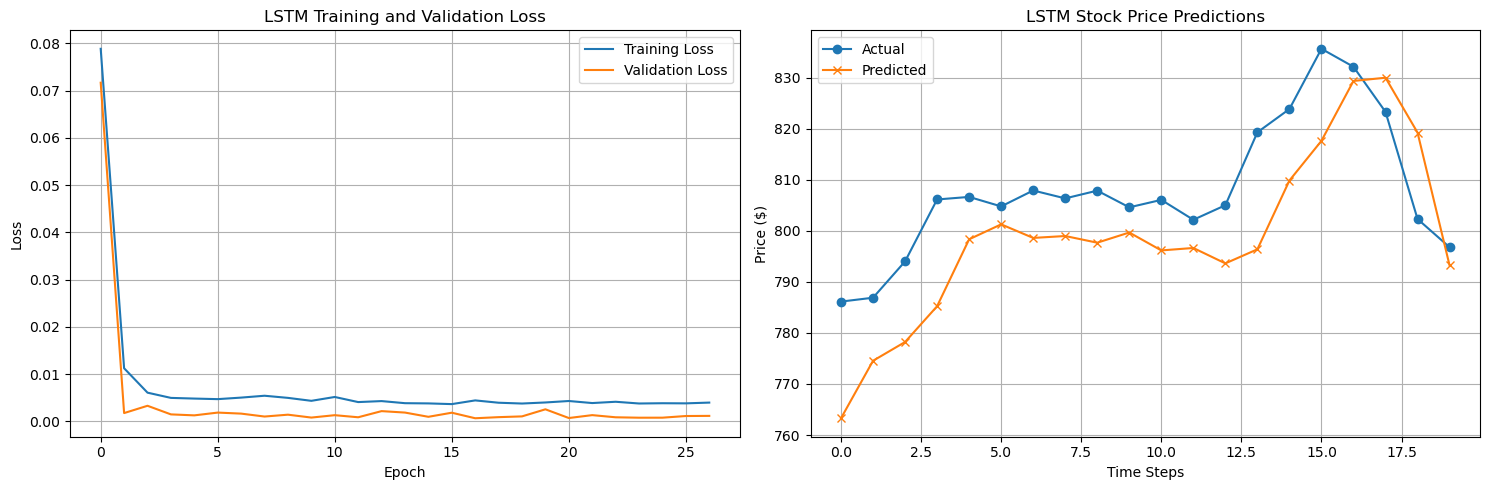


Results for LSTM:
RMSE: $12.98
MAPE: 1.41%
R² Score: -0.0162

Running experiment with configuration:
{'model_type': 'LSTM', 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.01}

Training LSTM model...
Epoch [10/100]
Training Loss: 0.005406
Validation Loss: 0.003350
Epoch [20/100]
Training Loss: 0.005877
Validation Loss: 0.009244
Early stopping triggered at epoch 27

LSTM Results:
RMSE: $10.52
MAPE: 0.95%
R² Score: 0.3325


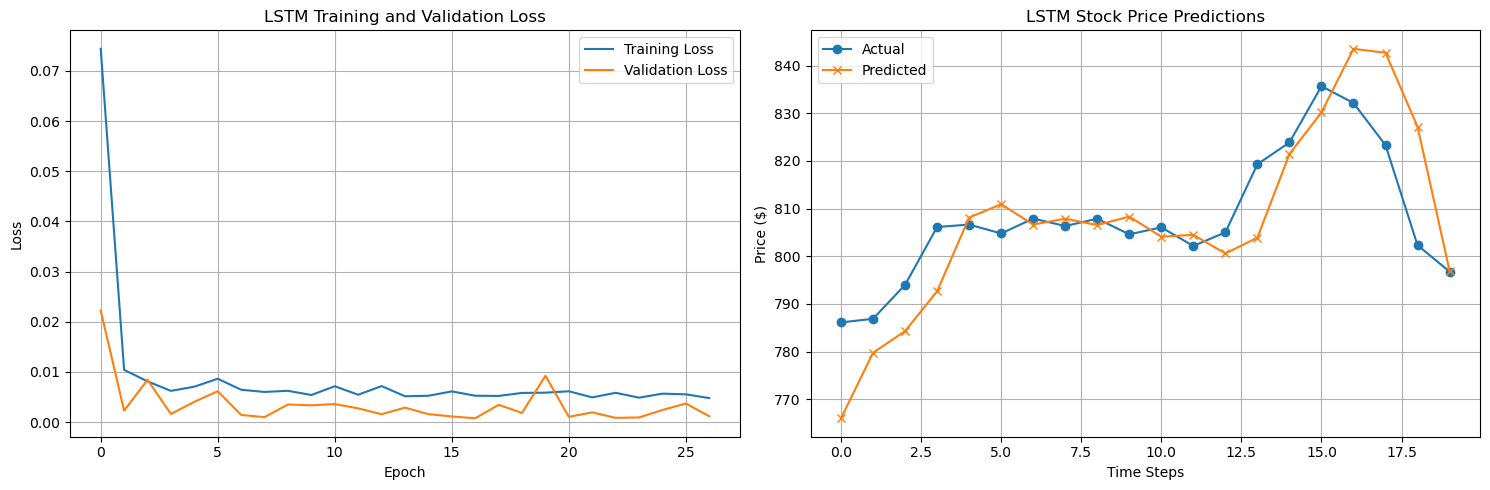


Results for LSTM:
RMSE: $10.52
MAPE: 0.95%
R² Score: 0.3325

Running experiment with configuration:
{'model_type': 'GRU', 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.2, 'learning_rate': 0.01}

Training GRU model...
Epoch [10/100]
Training Loss: 0.004567
Validation Loss: 0.001068
Epoch [20/100]
Training Loss: 0.003713
Validation Loss: 0.000724
Epoch [30/100]
Training Loss: 0.003505
Validation Loss: 0.000765
Early stopping triggered at epoch 36

GRU Results:
RMSE: $10.60
MAPE: 1.00%
R² Score: 0.3223


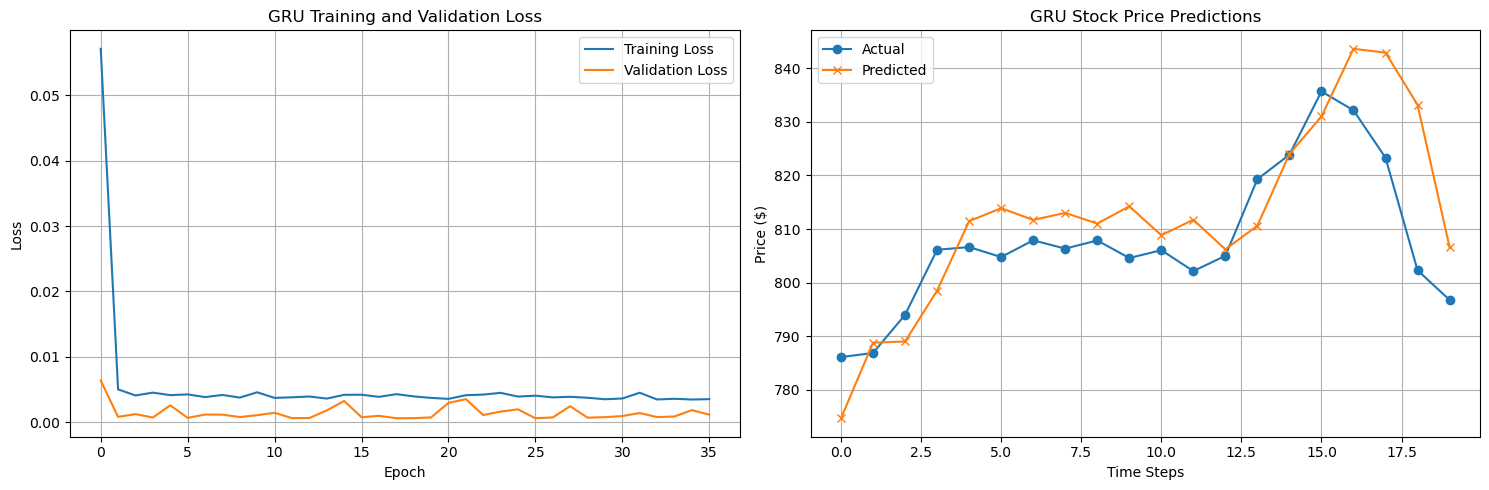


Results for GRU:
RMSE: $10.60
MAPE: 1.00%
R² Score: 0.3223

Running experiment with configuration:
{'model_type': 'GRU', 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.01}

Training GRU model...
Epoch [10/100]
Training Loss: 0.005653
Validation Loss: 0.002014
Epoch [20/100]
Training Loss: 0.005431
Validation Loss: 0.001512
Early stopping triggered at epoch 23

GRU Results:
RMSE: $15.90
MAPE: 1.77%
R² Score: -0.5247


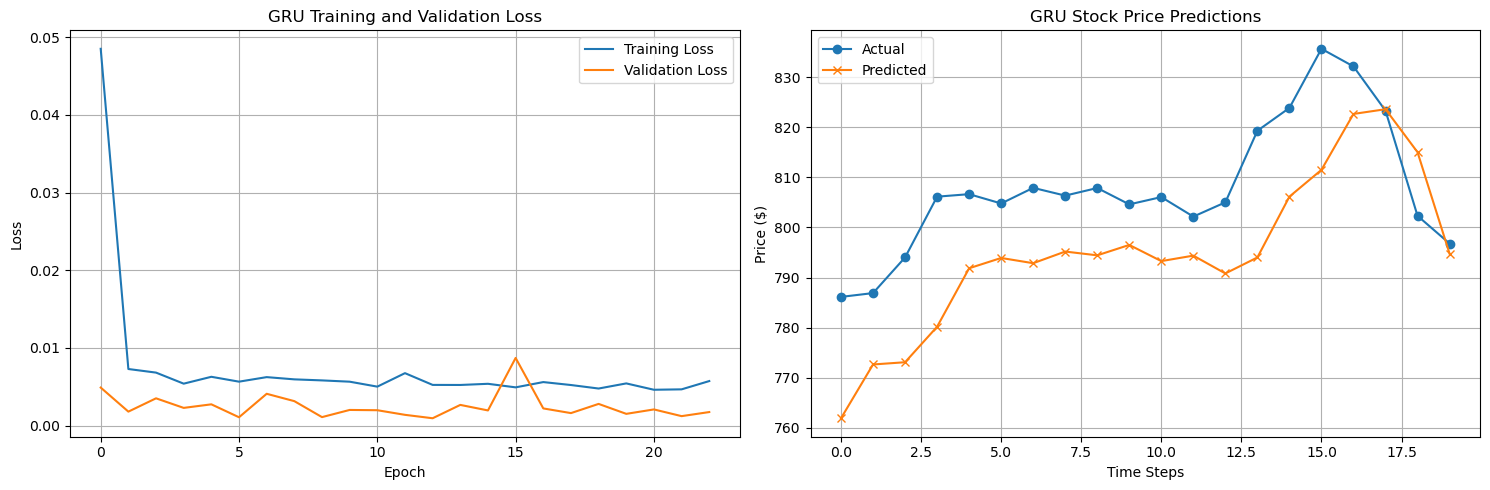


Results for GRU:
RMSE: $15.90
MAPE: 1.77%
R² Score: -0.5247

Running experiment with configuration:
{'model_type': 'RNN', 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.2, 'learning_rate': 0.01}

Training RNN model...
Epoch [10/100]
Training Loss: 0.003812
Validation Loss: 0.001241
Early stopping triggered at epoch 17

RNN Results:
RMSE: $8.19
MAPE: 0.74%
R² Score: 0.5954


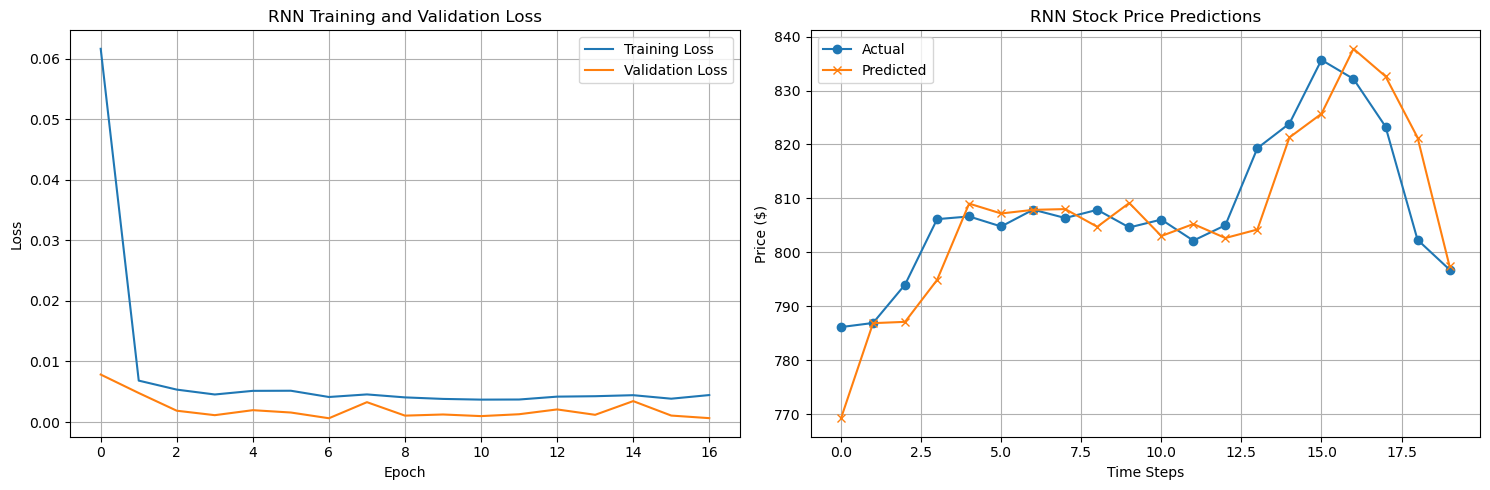


Results for RNN:
RMSE: $8.19
MAPE: 0.74%
R² Score: 0.5954

Running experiment with configuration:
{'model_type': 'LSTM', 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.01}

Training LSTM model...
Epoch [10/100]
Training Loss: 0.006957
Validation Loss: 0.002478
Epoch [20/100]
Training Loss: 0.005713
Validation Loss: 0.000748
Early stopping triggered at epoch 26

LSTM Results:
RMSE: $15.79
MAPE: 1.58%
R² Score: -0.5039


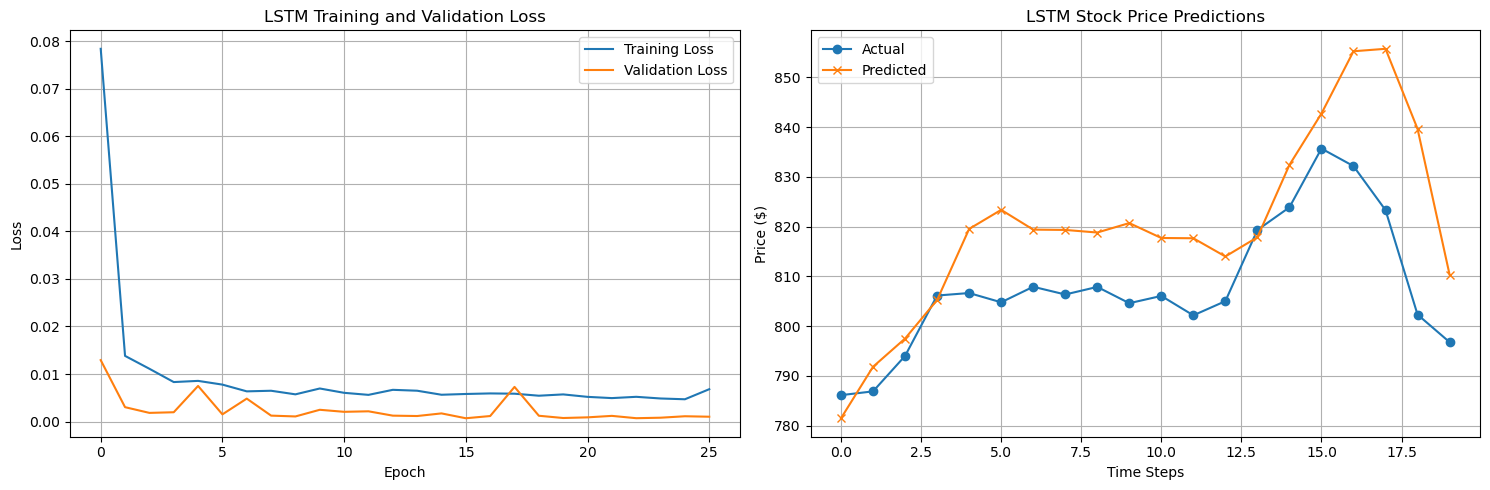


Results for LSTM:
RMSE: $15.79
MAPE: 1.58%
R² Score: -0.5039

Running experiment with configuration:
{'model_type': 'LSTM', 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.01}

Training LSTM model...
Epoch [10/100]
Training Loss: 0.006363
Validation Loss: 0.000976
Early stopping triggered at epoch 19

LSTM Results:
RMSE: $43.90
MAPE: 5.24%
R² Score: -10.6238


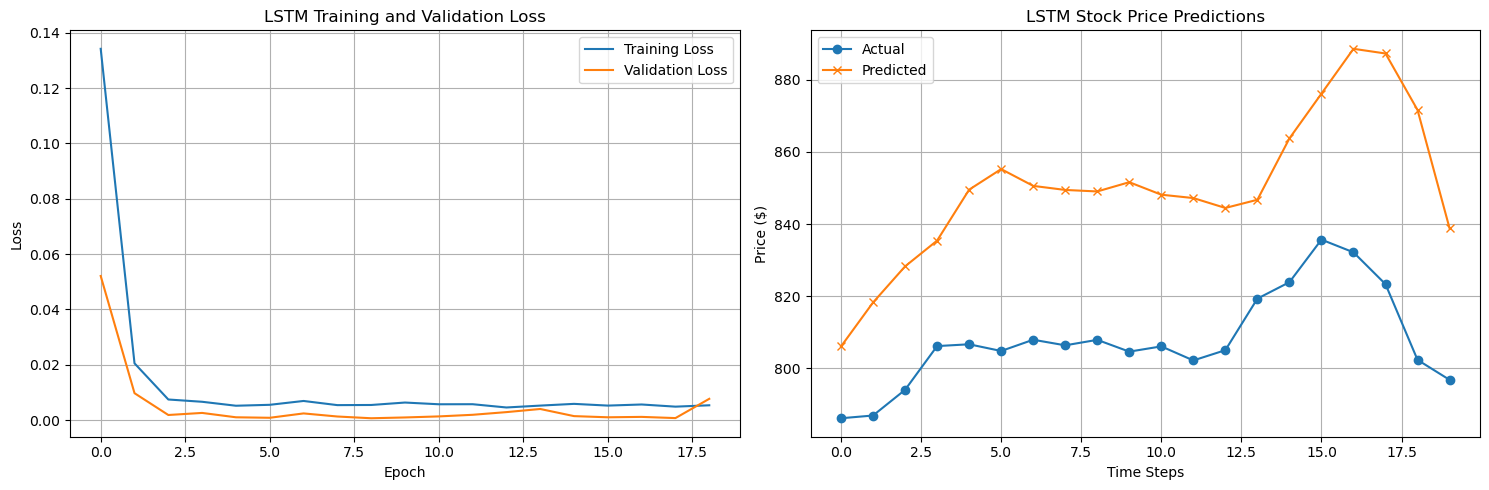


Results for LSTM:
RMSE: $43.90
MAPE: 5.24%
R² Score: -10.6238

Running experiment with configuration:
{'model_type': 'LSTM', 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.3, 'learning_rate': 0.01}

Training LSTM model...
Epoch [10/100]
Training Loss: 0.006366
Validation Loss: 0.003761
Epoch [20/100]
Training Loss: 0.006134
Validation Loss: 0.001005
Epoch [30/100]
Training Loss: 0.005860
Validation Loss: 0.000770
Epoch [40/100]
Training Loss: 0.005144
Validation Loss: 0.001383
Early stopping triggered at epoch 46

LSTM Results:
RMSE: $9.35
MAPE: 0.91%
R² Score: 0.4723


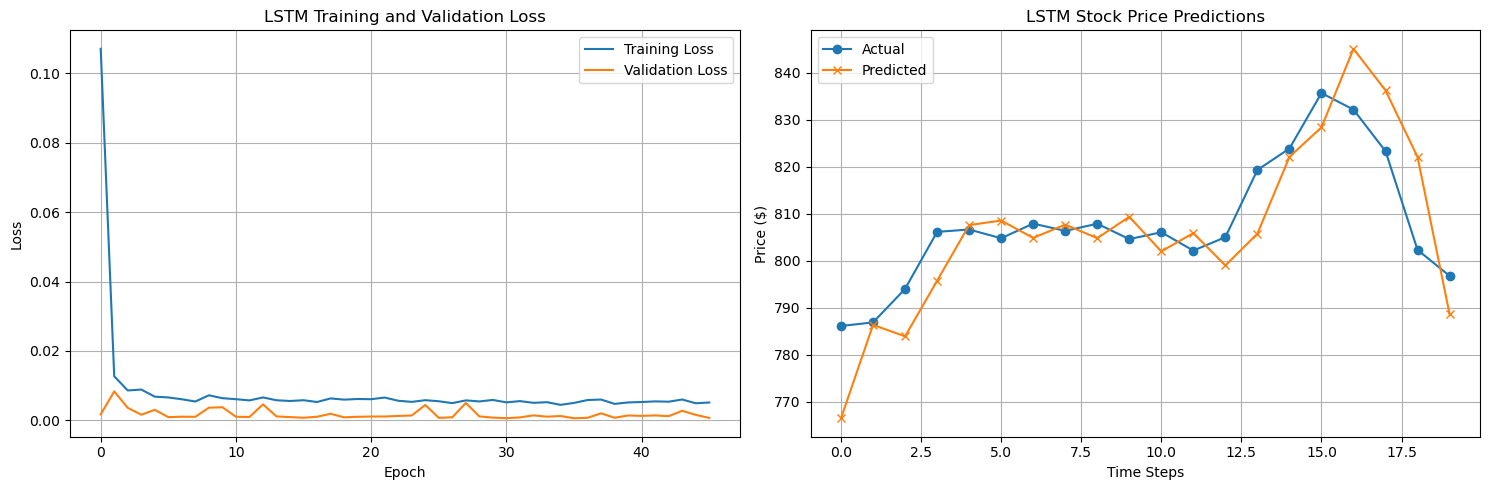


Results for LSTM:
RMSE: $9.35
MAPE: 0.91%
R² Score: 0.4723

Running experiment with configuration:
{'model_type': 'LSTM', 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.4, 'learning_rate': 0.01}

Training LSTM model...
Epoch [10/100]
Training Loss: 0.005941
Validation Loss: 0.000793
Early stopping triggered at epoch 20

LSTM Results:
RMSE: $11.46
MAPE: 1.07%
R² Score: 0.2075


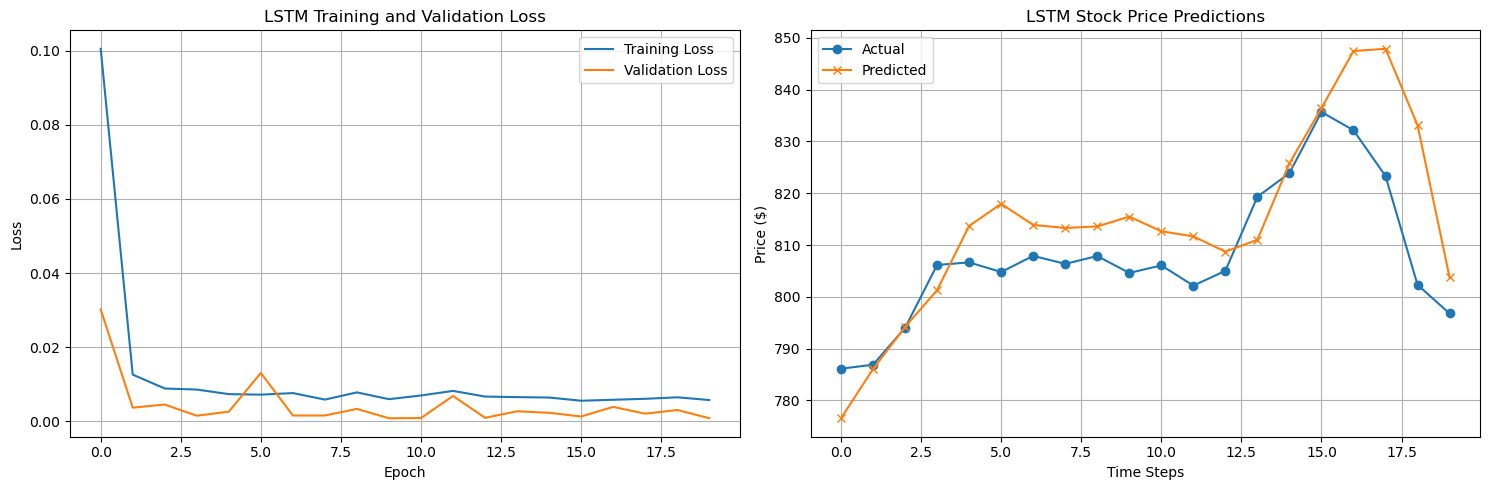


Results for LSTM:
RMSE: $11.46
MAPE: 1.07%
R² Score: 0.2075

Running experiment with configuration:
{'model_type': 'LSTM', 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.001}

Training LSTM model...
Epoch [10/100]
Training Loss: 0.008456
Validation Loss: 0.001663
Epoch [20/100]
Training Loss: 0.006958
Validation Loss: 0.001908
Epoch [30/100]
Training Loss: 0.005588
Validation Loss: 0.001332
Epoch [40/100]
Training Loss: 0.004995
Validation Loss: 0.000958
Epoch [50/100]
Training Loss: 0.005238
Validation Loss: 0.001578
Epoch [60/100]
Training Loss: 0.004657
Validation Loss: 0.001748
Epoch [70/100]
Training Loss: 0.004505
Validation Loss: 0.000902
Early stopping triggered at epoch 71

LSTM Results:
RMSE: $12.27
MAPE: 1.13%
R² Score: 0.0920


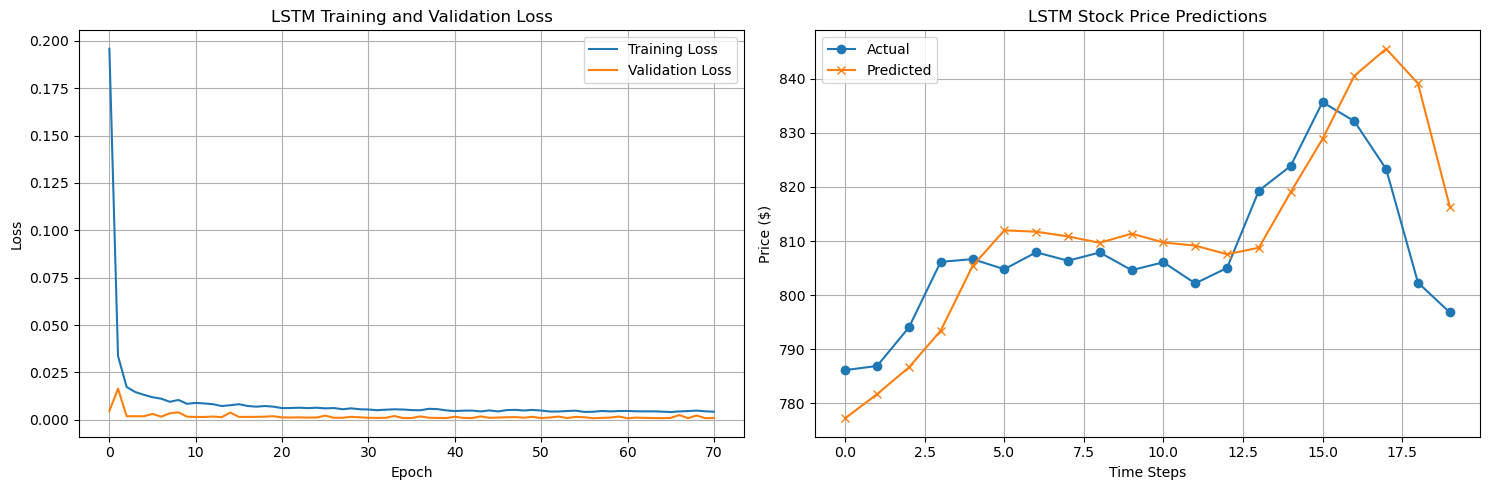


Results for LSTM:
RMSE: $12.27
MAPE: 1.13%
R² Score: 0.0920

Running experiment with configuration:
{'model_type': 'LSTM', 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.1}

Training LSTM model...
Epoch [10/100]
Training Loss: 0.014566
Validation Loss: 0.007144
Early stopping triggered at epoch 18

LSTM Results:
RMSE: $54.85
MAPE: 6.34%
R² Score: -17.1501


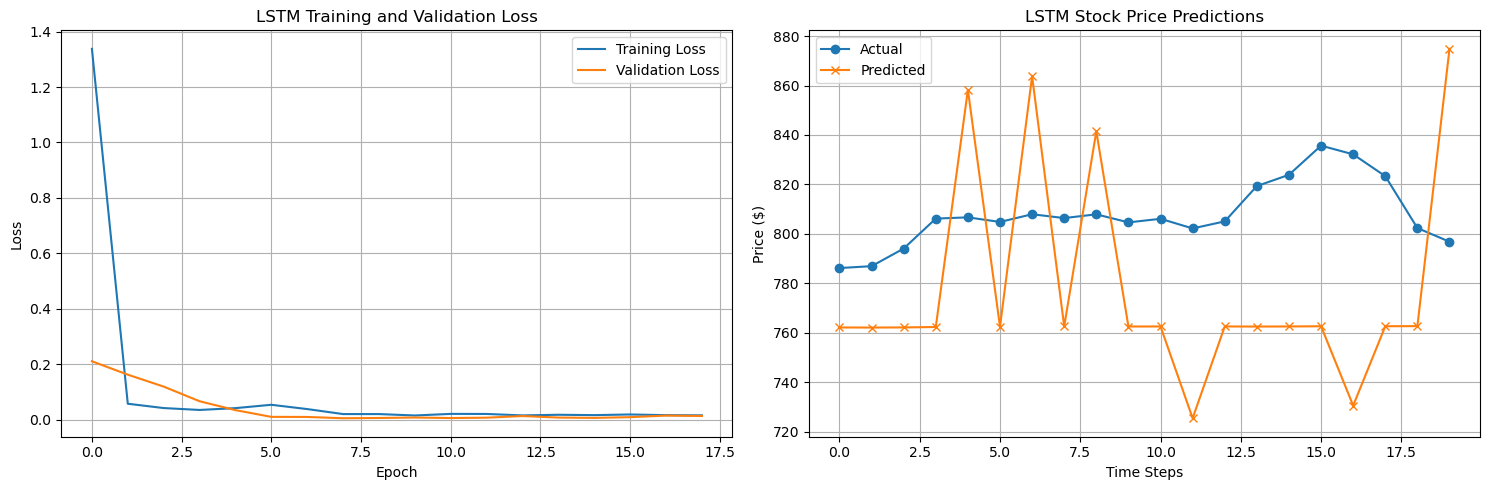


Results for LSTM:
RMSE: $54.85
MAPE: 6.34%
R² Score: -17.1501

Experiment Results Summary (sorted by RMSE):
   model_type  hidden_size  num_layers  learning_rate  dropout       rmse  \
4         RNN           64           1          0.010      0.2   8.189899   
7        LSTM           64           2          0.010      0.3   9.353590   
1        LSTM           64           2          0.010      0.2  10.519341   
2         GRU           64           1          0.010      0.2  10.599443   
8        LSTM           64           2          0.010      0.4  11.462129   
9        LSTM           64           2          0.001      0.2  12.269298   
0        LSTM           64           1          0.010      0.2  12.979554   
5        LSTM           32           2          0.010      0.2  15.789738   
3         GRU           64           2          0.010      0.2  15.898832   
6        LSTM          128           2          0.010      0.2  43.897594   
10       LSTM           64           2      

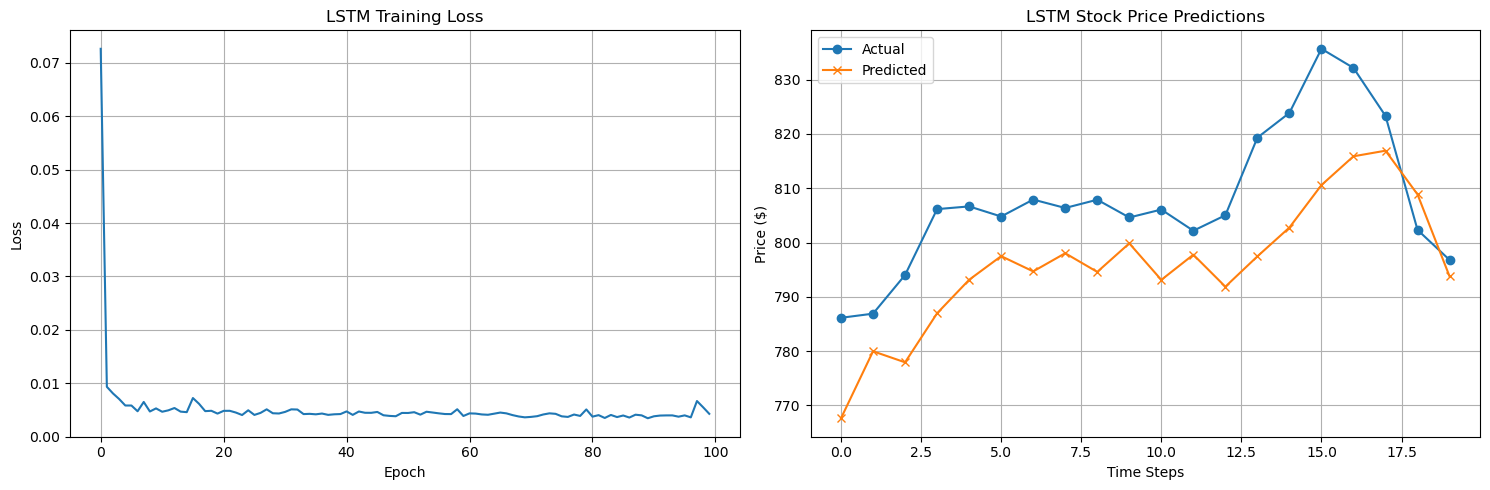


Testing LSTM model (Hidden Size: 64)

Training...
Epoch [10/100], Loss: 0.004046


In [8]:



# Main execution
if __name__ == "__main__":
    # Define experiment configurations
    configurations = [
        # Basic models with varying layers
        {'model_type': 'LSTM', 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.2, 'learning_rate': 0.01},
        {'model_type': 'LSTM', 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.01},
        {'model_type': 'GRU', 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.2, 'learning_rate': 0.01},
        {'model_type': 'GRU', 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.01},
        {'model_type': 'RNN', 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.2, 'learning_rate': 0.01},

        # Models with varying hidden sizes
        {'model_type': 'LSTM', 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.01},
        {'model_type': 'LSTM', 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.01},

        # Models with varying dropout rates
        {'model_type': 'LSTM', 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.3, 'learning_rate': 0.01},
        {'model_type': 'LSTM', 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.4, 'learning_rate': 0.01},

        # Models with varying learning rates
        {'model_type': 'LSTM', 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.001},
        {'model_type': 'LSTM', 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.1}
    ]

    # Run experiments
    results = []
    for config in configurations:
        print(f"\nRunning experiment with configuration:")
        print(config)
        try:
            result = run_experiment(**config)
            if result:  # Make sure we have a valid result
                # Ensure all required fields are present
                required_fields = ['model_type', 'hidden_size', 'num_layers',
                                 'learning_rate', 'dropout', 'rmse', 'mape', 'r2']
                if all(field in result for field in required_fields):
                    results.append(result)
                else:
                    print(f"Warning: Missing required fields in result for {config['model_type']}")
        except Exception as e:
            print(f"Error running experiment with config {config['model_type']}: {str(e)}")

    # Print summary
    if results:
        print("\nExperiment Results Summary (sorted by RMSE):")
        results_df = pd.DataFrame(results)
        # Select specific columns for display
        display_columns = ['model_type', 'hidden_size', 'num_layers',
                         'learning_rate', 'dropout', 'rmse', 'mape', 'r2']
        results_df = results_df[display_columns]
        print(results_df.sort_values('rmse'))
    else:
        print("\nNo valid results to display")

    # Additional Analysis Functions
    def analyze_model_performance(model, train_loader, val_loader, test_loader, scaler, config):
        """Comprehensive model analysis including training, validation, and testing"""

        # Training setup
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

        print(f"\nTraining {config['model_type']} model...")

        # Train model
        train_losses, val_losses = train_model(
            model, train_loader, val_loader, criterion, optimizer)

        # Test model
        predictions, actuals, rmse, mape, r2 = evaluate_model(model, test_loader, scaler)

        # Create visualizations
        plt.figure(figsize=(20, 10))

        # 1. Training and Validation Loss
        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title(f'{config["model_type"]} Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # 2. Predictions vs Actual
        plt.subplot(2, 2, 2)
        plt.plot(actuals, label='Actual', marker='o')
        plt.plot(predictions, label='Predicted', marker='x')
        plt.title(f'{config["model_type"]} Stock Price Predictions')
        plt.xlabel('Time Steps')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True)

        # 3. Price Change Analysis
        price_changes = np.diff(actuals)
        pred_changes = np.diff(predictions)
        plt.subplot(2, 2, 3)
        plt.scatter(price_changes, pred_changes)
        plt.plot([-50, 50], [-50, 50], 'r--')  # Perfect prediction line
        plt.title('Price Change Analysis')
        plt.xlabel('Actual Price Change ($)')
        plt.ylabel('Predicted Price Change ($)')
        plt.grid(True)

        # 4. Prediction Error Distribution
        plt.subplot(2, 2, 4)
        errors = predictions - actuals
        plt.hist(errors, bins=20)
        plt.title('Prediction Error Distribution')
        plt.xlabel('Prediction Error ($)')
        plt.ylabel('Frequency')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Market condition analysis
        up_days = price_changes > 0
        down_days = price_changes < 0

        print(f"\nMarket Condition Analysis for {config['model_type']}:")
        print("-----------------------------------------")
        print(f"Upward Trend MAPE: {mean_absolute_percentage_error(actuals[1:][up_days], predictions[1:][up_days])*100:.2f}%")
        print(f"Downward Trend MAPE: {mean_absolute_percentage_error(actuals[1:][down_days], predictions[1:][down_days])*100:.2f}%")

        return {
            'model_type': config['model_type'],
            'hidden_size': config['hidden_size'],
            'rmse': rmse,
            'mape': mape,
            'r2': r2,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'predictions': predictions,
            'actuals': actuals
        }

    # Function to test final models
    def test_final_model(config):
        """Test a model configuration and print detailed results"""
        print(f"\nTesting {config['model_type']} model (Hidden Size: {config['hidden_size']})")

        # Load and prepare data
        train_data = pd.read_csv('Google_Stock_Price_Train.csv')
        test_data = pd.read_csv('Google_Stock_Price_Test.csv')

        # Prepare data
        X_train, y_train, X_test, y_test, scaler = prepare_data(train_data, test_data)

        # Create datasets
        train_dataset = StockDataset(X_train, y_train)
        test_dataset = StockDataset(X_test, y_test)

        # Create data loaders
        batch_size = 32
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        # Initialize model based on type
        if config['model_type'] == 'LSTM':
            model = BasicLSTM(hidden_size=config['hidden_size'],
                            num_layers=config['num_layers'],
                            dropout=config['dropout'])
        elif config['model_type'] == 'GRU':
            model = BasicGRU(hidden_size=config['hidden_size'],
                           num_layers=config['num_layers'],
                           dropout=config['dropout'])
        else:  # RNN
            model = BasicRNN(hidden_size=config['hidden_size'],
                           num_layers=config['num_layers'],
                           dropout=config['dropout'])

        # Set up training
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

        print("\nTraining...")
        losses = []
        for epoch in range(100):
            model.train()
            total_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            losses.append(avg_loss)

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/100], Loss: {avg_loss:.6f}')

        # Test model
        print("\nTesting...")
        # Ensure we're using the test_loader and scaler from this function
        predictions, actuals, rmse, mape, r2 = evaluate_model(model, test_loader, scaler)

        # Print results
        print(f"\nResults for {config['model_type']} (Hidden Size: {config['hidden_size']}):")
        print(f"RMSE: ${rmse:.2f}")
        print(f"MAPE: {mape*100:.2f}%")
        print(f"R² Score: {r2:.4f}")

        # Plot results
        plt.figure(figsize=(15, 5))

        # Training loss
        plt.subplot(1, 2, 1)
        plt.plot(losses)
        plt.title(f'{config["model_type"]} Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)

        # Predictions
        plt.subplot(1, 2, 2)
        plt.plot(actuals, label='Actual', marker='o')
        plt.plot(predictions, label='Predicted', marker='x')
        plt.title(f'{config["model_type"]} Stock Price Predictions')
        plt.xlabel('Time Steps')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        return {
            'model_type': config['model_type'],
            'hidden_size': config['hidden_size'],
            'rmse': rmse,
            'mape': mape,
            'r2': r2,
            'predictions': predictions,
            'actuals': actuals
        }

    # Final configurations to test
    final_configs = [
        {
            'model_type': 'LSTM',
            'hidden_size': 32,
            'num_layers': 2,
            'dropout': 0.2,
            'learning_rate': 0.01
        },
        {
            'model_type': 'LSTM',
            'hidden_size': 64,
            'num_layers': 2,
            'dropout': 0.2,
            'learning_rate': 0.01
        },
        {
            'model_type': 'GRU',
            'hidden_size': 64,
            'num_layers': 2,
            'dropout': 0.2,
            'learning_rate': 0.01
        }
    ]

    # Test final models
    final_results = []
    for config in final_configs:
        result = test_final_model(config)
        final_results.append(result)

    # Print final comparison
    print("\nFinal Model Comparison:")
    comparison_df = pd.DataFrame(final_results)[['model_type', 'hidden_size', 'rmse', 'mape', 'r2']]
    print(comparison_df.sort_values('rmse'))

    # Plot all predictions together
    plt.figure(figsize=(12, 6))
    plt.plot(final_results[0]['actuals'], label='Actual', marker='o')
    for result in final_results:
        plt.plot(result['predictions'],
                label=f"{result['model_type']}-{result['hidden_size']}",
                marker='x')
    plt.title('All Models Prediction Comparison')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
